In [11]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from datetime import datetime
import cv2
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)



def create_optimizer(model, lr0):
    params = [{'params': model.customer.parameters(), 'lr': lr0/3},
              {'params': model.evt1.parameters(), 'lr': lr0/9},
              {'params': model.evt2.parameters(), 'lr': lr0/9},
              {'params': model.linear1.parameters(), 'lr': lr0},
             {'params': model.linear2.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [15]:
class NN(nn.Module):
    def __init__(self, num_customer, num_evt1, num_evt2 ,num_prod, emb_size_cus = 50, emb_size = 5):
        super(NN, self).__init__()
        self.customer = nn.Embedding(num_customer, emb_size_cus)
        self.evt1 = nn.Embedding(num_evt1, emb_size)
        self.evt2 = nn.Embedding(num_evt2, emb_size)
        self.linear1 = nn.Linear(emb_size*2+emb_size_cus+2, 32)
        self.linear2 = nn.Linear(32, num_prod)
        #self.linear3 = nn.Linear(16, num_prod)
        self.nolinear1 = nn.ReLU()
        self.nolinear2 = nn.LeakyReLU()
        self.last = nn.Softmax(1)
        
    def forward(self, x_train_val):
        c = self.customer(x_train_val[:,0])
        evt1 = self.evt1(x_train_val[:,3])
        evt2 = self.evt2(x_train_val[:,4])
        X = torch.cat([c,evt1, evt2, x_train_val[:,1:3]],1)
        pred = self.linear1(X)
        pred = self.nolinear1(pred)
        pred = self.linear2(pred)
#         pred = self.nolinear2(pred)
#         pred = self.linear3(pred)
#         pred = self.last(pred)
        return pred

In [ ]:
lrs = get_cosine_triangular_lr(max_lr=0.01, iterations=1000)
lrs = get_cosine_triangular_lr(max_lr, iterations)
optimizer = create_optimizer(model, lrs[0])    
lr = lrs[1]
update_optimizer(optimizer, [lr/3, lr/9,lr/9, lr,lr])

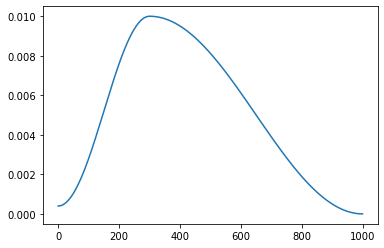

In [31]:
plt.plot(lrs)

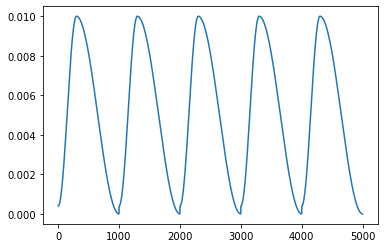

In [30]:
plt.plot(np.tile(lrs, 5))